#### Project Description
Optiver, a globally renowned high-frequency trading company, is organizing a Kaggle competition focused on discovering optimal volatility prediction models. The objective is to forecast short-term volatility for numerous stocks spanning various sectors. With access to millions of rows of detailed financial data, the challenge is to anticipate volatility over 10-minute intervals.


In [10]:
# !pip install kaggle
# !pip install pyarrow
# !pip install statsmodels
# !pip install xgboost
# !kaggle competitions download -c optiver-realized-volatility-prediction
# ! mkdir input
# ! mv optiver-realized-volatility-prediction.zip input/
# ! cd input && unzip -o optiver-realized-volatility-prediction.zip
from sklearn.model_selection import GridSearchCV,  train_test_split, KFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
import multiprocess as mp
from functools import reduce
import statsmodels.api as sm
import xgboost as xgb
import lightgbm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import random, os


########  USEFUL FUNCTIONS  ################

files = []
for dirname, _, filenames in os.walk('input'):
    for filename in filenames:
        files.append(os.path.join(dirname, filename))
print (' ---  loading %d   files --- '%(len(files)))


 ---  loading 230   files --- 


In [2]:
"""formula """
def WAP1(book):
    return(book.bid_price1*book.ask_size1 + book.ask_price1*book.bid_size1) / (book.bid_size1 + book.ask_size1)

def WAP2(book):
    return(book.bid_price2*book.ask_size2 + book.ask_price2*book.bid_size2) / (book.bid_size2 + book.ask_size2)

def make_title(x):
    return '**'*10+ '  ' +x +'  '+'**'*10+'\n'

def get_price(stock_id, book_trade, train_test='train'):
    return [f for f in files if f'stock_id={stock_id}/' in f and book_trade in f and train_test in f]

def rmspe(y_true, y_pred):
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))


#### About the Data
The dataset contains information from 3830 10-minute segments, which have been sampled from a total of 32767 10-minute segments across 112 stocks from 3 years historical trading data.

Data Provided:
- input/book_train.parquet:  order book data
- input/trade_train.parquet: trade data


target - The realized volatility computed over the 10 minute window following the feature data under the same stock/time_id. There is no overlap between feature and target data. You can find more info in our tutorial notebook.
**we only need to predict for stock id 0**

row_id - Unique identifier for the submission row. There is one row for each existing time ID/stock ID pair. Each time window is not necessarily containing every individual stock.


stock_id - ID code for the stock. Not all stock IDs exist in every time bucket. Parquet coerces this column to the categorical data type when loaded; you may wish to convert it to int8.

time_id - ID code for the time bucket. Time IDs are not necessarily sequential but are consistent across all stocks.
seconds_in_bucket - Number of seconds from the start of the bucket, always starting from 0.

bid_price[1/2] - Normalized prices of the most/second most competitive buy level.

ask_price[1/2] - Normalized prices of the most/second most competitive sell level.

bid_size[1/2] - The number of shares on the most/second most competitive buy level.

ask_size[1/2] - The number of shares on the most/second most competitive sell level.



In [3]:
train = pd.read_csv('input/train.csv')
book_example = pq.read_table(get_price(0, 'book')[0]).to_pandas()
trade_example = pq.read_table(get_price(0, 'trade')[0]).to_pandas()

print(make_title('target - y_true'))
display(train.head())
print (make_title('order book example '),book_example.head(3))
print (make_title('trade example '),trade_example.head(3))


stock_ids = train.stock_id.unique()
print('\nstock_ids: total number of stocks: %d '%(len(stock_ids)))

********************  target - y_true  ********************



,stock_id,time_id,target
0,0,5,0.004136
1,0,11,0.001445
2,0,16,0.002168
3,0,31,0.002195
4,0,62,0.001747


********************  order book example   ********************
    time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2   
0        5                  0    1.001422    1.002301     1.00137    1.002353  \
1        5                  1    1.001422    1.002301     1.00137    1.002353   
2        5                  5    1.001422    1.002301     1.00137    1.002405   

   bid_size1  ask_size1  bid_size2  ask_size2  
0          3        226          2        100  
1          3        100          2        100  
2          3        100          2        100  
********************  trade example   ********************
    time_id  seconds_in_bucket     price  size  order_count
0        5                 21  1.002301   326           12
1        5                 46  1.002778   128            4
2        5                 50  1.002818    55            1

stock_ids: total number of stocks: 112 


#### Formulas
**Realized volatility**
When we trade options, a valuable input to our models is the standard deviation of the stock log returns. The standard deviation will be different for log returns computed over longer or shorter intervals, for this reason it is usually normalized to a 1-year period and the annualized standard deviation is called volatility.

In this competition, you will be given 10 minutes of book data and we ask you to predict what the volatility will be in the following 10 minutes. Volatility will be measured as follows:

We will compute the log returns over all consecutive book updates and we define the realized volatility,  𝜎 as the squared root of the sum of squared log returns, P as price


$WAP =\text{Weighted Average Price}= \dfrac{P_{bid} \times Size_{ask}+Size_{bid}\times P_{ask}}{Size_{bid}+ Size_{ask}}$

$\sigma=\sqrt{\sum r_{t-1,t}^2} \; , \quad\quad  r_{t1,t2}=log(\dfrac{S_{t2}}{S_{t1}})= log(S_{t2})-log(S_{t1})$

$\text{bid ask spread}= \dfrac{P_{ask}-P_{bid}}{P_{ask}}$
 
Where we use WAP price to compute log returns, P stands for price.


#### EDA
task for week2
1. plot to see calculated realized vol with target in the train set ✓
2. check the correlation ✓
3. Simpler Linear regression ✓
4. Submit 

task for week3-4
1. create a table with index=stock_id, title=time_id, data=[vol1,vol2,vol3,vol4.....], - create an ETF column and see if individual stocks vol is dep on ETF vol  ✓
2. then add ETF col to regression model each time_id, compute mean of vol across all stock_ids
3. then calculate new R-sqr
4. look at the raw data again, try to get more information. e.g first-5-min-vol
5. try to group stocks. try clustering, to see if stock can grouped.


In [ ]:
def ref_time_EDA():
    sample0=train.query("stock_id==0")
    sample10=train.query("stock_id==10")
    id_is_same = (sample10['time_id']-sample0['time_id']).abs().sum()
    
    print ('If time_id of stock id 0 and 10 is the same: ',id_is_same==0)
    print ('max time id is ',sample0['time_id'].max(), ',  count of time id' , sample0['time_id'].nunique())
    
def ref_price_EDA(stock_id,time_id): 
    df_book = pq.read_table(get_price(stock_id, 'book')[0]).to_pandas()
    df_trade = pq.read_table(get_price(stock_id, 'trade')[0]).to_pandas()
    print (make_title('book'),df_book.head())
    print (make_title('trade'),df_trade.head())
    book =  df_book.loc[df_book["time_id"]==time_id]
    trade =  df_trade.loc[df_trade["time_id"]==time_id]

    book['WAP1']= WAP1(book)
    book['WAP2']= WAP2(book)
    #[(book, column name, linewidth)]
    samples = [
        (book,'bid_price1',1.0),
        (book,'bid_price2',1.0),
        (book,'ask_price1',1.0),
        (book,'ask_price2',1.0),
        (trade,'price',3.0),
        ]
    
#     plt.figure(figsize=(20,5))
    fig, ax = plt.subplots(nrows=2, ncols=1,  figsize=(20, 10),sharex=True,squeeze=True)

    for num, (bk, col,lw) in enumerate(samples):
        ax[0].plot(bk["seconds_in_bucket"],bk[col],label=col,linewidth=lw)
    ax[0].set_xlabel('seconds')
    ax[0].legend()
#     plt.title('order book prices of stock_id %d time_id %d (10 min period)'%(stock_id, time_id))
#     plt.show()
    
    trade.plot(x='seconds_in_bucket',y='price',ax=ax[1])
    book.plot(x='seconds_in_bucket',y='WAP1',ax=ax[1])
    book.plot(x='seconds_in_bucket',y='WAP2',ax=ax[1])

ref_time_EDA()  
ref_price_EDA(stock_id=0, time_id=16)

Ref 
1. 112 stocks,3 years of data, each data point represents 10 min bucket
2. each 10-min bucket has a corresponding time_id
3. time bins r discontinuous, should not use rolling functions
4. in the 10-mib bucket, not all book or trade has data in every sec. the distribution is different too
5. they will try simple LightGBM

Our takeaways
Machine Learning Procedural Improvements:
1. Read the problem more carefuly, with extra attention to formulae (wap)
2. Plot the data, and plots of meta data to check our assumptions more carefully
3. Read the data again check for accidental overlaps between different sets of data

#### Feature engineering 
##### On order book table and trade: 
Feature engineering is essential to address these challenges. By leveraging fundamental finance concepts such as bid-ask spread and realized volatility, we can generate new features that enhance model performance.

- Price spread: The difference between the bid and ask prices. A larger price spread indicates lower liquidity, which in turn implies potential higher volatility.

- Volume: The total quantity of buy and sell orders. Lower volume suggests lower liquidity, which can lead to potential higher volatility.

- Volume imbalance: The difference between buy and sell volumes. A larger difference indicates a greater imbalance between buying and selling pressure, which implies potential higher volatility.

In [4]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

def log_return(series):
    return np.log(series).diff()

def plot_log_return(df, time_id):
    df.loc[df['time_id']==5].plot(x='seconds_in_bucket', y='logret1',title='log return')

def calc_book(stock_id, debug=False):
    """    improvements: calculate following features only using the last 300 sec 
    train_test: str "train" or "test"
    """
    # df_trade = pq.read_table(get_price(stock_id, 'trade')[stock_id]).to_pandas()
    df_book = pq.read_table(get_price(stock_id, 'book')[0]).to_pandas()
#     waited average price
    df_book['wap1']= WAP1(df_book)
    df_book['wap2']= WAP2(df_book)
    df_book['logret1']= df_book.groupby('time_id')['wap1'].apply(log_return).values
    df_book['logret2']= df_book.groupby('time_id')['wap2'].apply(log_return).values
    df_book['wap_balance'] = abs(df_book['logret1']-df_book['logret2'])
    df_book['ret_sqr'] = df_book['logret1']**2
    df_book['ret_sqr2'] = df_book['logret2']**2
    
    df_book['price_spread']= (df_book.ask_price1 - df_book.bid_price1 )* 2 / (df_book.ask_price1 + df_book.bid_price1)
    
    df_book['bid_spread'] = df_book['bid_price1']-df_book['bid_price2']
    df_book['ask_spread'] = df_book['ask_price1']-df_book['ask_price2']
    df_book['total_volume'] = df_book['bid_size1']+df_book['bid_size2']+df_book['ask_size1']+df_book['ask_size2']
    df_book['volume_spread'] = abs(df_book['bid_size1']+df_book['bid_size2']-df_book['ask_size1']-df_book['ask_size2'])


    df_vol = df_book.groupby(['time_id']).agg \
        (
            vol=('ret_sqr',sum),
            wap = ('wap1',np.mean),
            wap_balance =('wap_balance',np.mean),
            price_spread = ('price_spread',np.mean),
            bid_spread = ('bid_spread',np.mean),
            ask_spread = ('ask_spread',np.mean),
            total_volume=('total_volume',np.mean),
            volume_spread=('volume_spread',np.mean),
        )
    df_vol['vol_300'] = np.sqrt(df_book[df_book.seconds_in_bucket >= 300].groupby(['time_id']).agg(vol300=('ret_sqr',sum))['vol300'])
    df_vol['vol'] = np.sqrt(df_vol['vol'])
    df_vol['stock_id'] = stock_id  
    return df_vol

def processor_book(mode='train'):
    with mp.Pool(4) as pool:
        df_vol= pool.map(calc_book, stock_ids)
    return pd.concat(df_vol, axis=0)


In [5]:
def cal_trade(stock_id):
    df_trade = pq.read_table(get_price(stock_id, book_trade='trade')[0]).to_pandas()
    df_vol = df_trade.groupby(['time_id']).agg \
        (
            price_mean=('price',np.mean),
            price_max = ('price','max'),
            price_min = ('price','min'),
            price_std = ('price', 'std'),
            frequency = ('seconds_in_bucket','count')
        )
    df_vol.loc[df_vol['frequency']<=1,'price_std']=0
    df_vol['stock_id'] = stock_id    
    return df_vol

def processor_trade():
    with mp.Pool(4) as pool:
        df_vol= pool.map(cal_trade, stock_ids)
    df_vol = pd.concat(df_vol, axis=0)
    return df_vol



In [6]:
new_book= processor_book()
print (make_title('new features obtained from order book '))
print (new_book.head(3))
new_trade = processor_trade()
print (make_title('new features obtained from trade data '))
print (new_trade.head(3))
df_out = reduce(lambda  left,right: pd.merge(left,right,on=['stock_id','time_id'],
                                           ), [train, new_book,new_trade])

********************  new features obtained from order book   ********************

              vol       wap  wap_balance  price_spread  bid_spread   
time_id                                                              
5        0.004499  1.003725     0.000319      0.000852    0.000176  \
11       0.001204  1.000239     0.000121      0.000394    0.000142   
16       0.002369  0.999542     0.000268      0.000725    0.000197   

         ask_spread  total_volume  volume_spread   vol_300  stock_id  
time_id                                                               
5         -0.000151    323.496689     134.894040  0.002953         0  
11        -0.000135    411.450000     142.050000  0.000981         0  
16        -0.000198    416.351064     141.414894  0.001295         0  
********************  new features obtained from trade data   ********************

         price_mean  price_max  price_min  price_std  frequency  stock_id
time_id                                             

In [7]:
# df_out

##### correlation map
- plot correlation heat map
- check for multicollinearity
- remove columns with high correlations (keep the one that has higher correlation to target)

##### drop stock id and replace with unique properties of the stock

- Since the stock_id represents a unique identifier for each stock, it should not be treated as an input column. Hence, our approach involves utilizing alternative properties to distinguish between stocks, such as average target and average standard deviation.

- split dataframe to train and test based on train_ids and test_ids


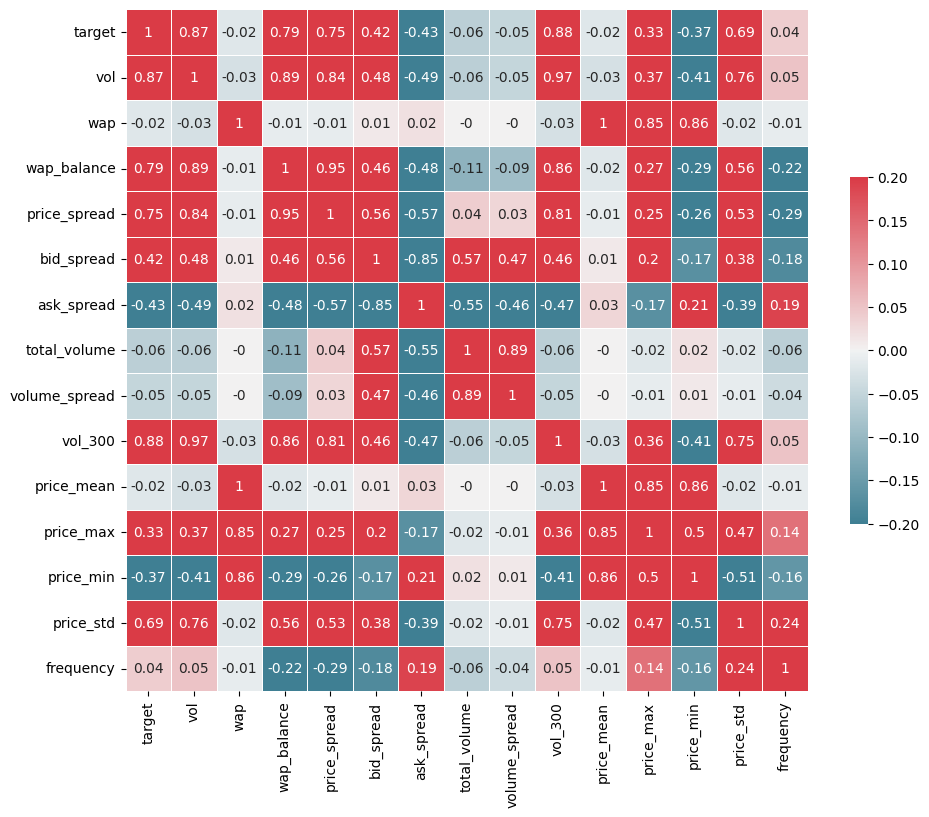

In [40]:
def corr_heatmap(data):
    df = data.copy()
    col = ['target']+list(df)[3::]
    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(df[col].corr(numeric_only=True).round(2), cmap=cmap, vmax=0.2, vmin=-0.2, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
corr_heatmap(df_out)

In [11]:
def processing_train_test(data):
    """replace stockid with target mean"""
    if data is None:
        book  = processor_book()
        trade = processor_trade()
        df = reduce(lambda  left,right: pd.merge(left,right,on=['stock_id','time_id'],
                                               ), [train, book,trade])
    else:
        df = data.copy()
    print ('data size: ',len(df))
    stock_id_target_mean = df.groupby('stock_id')['target'].mean() 
    X, y = df.drop(columns=['target']),  df['target']
    return X,y

X, y = processing_train_test(data=df_out)
Xtrain, Xtest, ytrain, ytest =  train_test_split(X,y, test_size=0.3, random_state=42)

data size:  428913


#### Modelling
- Linear Regression
    - t value is coefficient divided by the standard error
- XGBoost
- LightBGM

In [12]:
def LRG_model(X_train, X_test, y_train, y_test):
    X2 = sm.add_constant(X_train)
    est = sm.OLS(y_train, X2)
    est2 = est.fit()
    reg = LinearRegression().fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    print ('Performance  R square: %.3f \t|\t RMSPE :%.3f'%(metrics.r2_score(y_test, y_pred), rmspe(y_test, y_pred)))
    print(est2.summary())
    
print (make_title('Regression Model '))
LRG_model(Xtrain, Xtest, ytrain, ytest)

********************  Regression Model   ********************

Performance  R square: 0.781 	|	 RMSPE :0.334
                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.786
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                 6.903e+04
Date:                Mon, 08 Apr 2024   Prob (F-statistic):               0.00
Time:                        21:06:22   Log-Likelihood:             1.5572e+06
No. Observations:              300239   AIC:                        -3.114e+06
Df Residuals:                  300222   BIC:                        -3.114e+06
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------

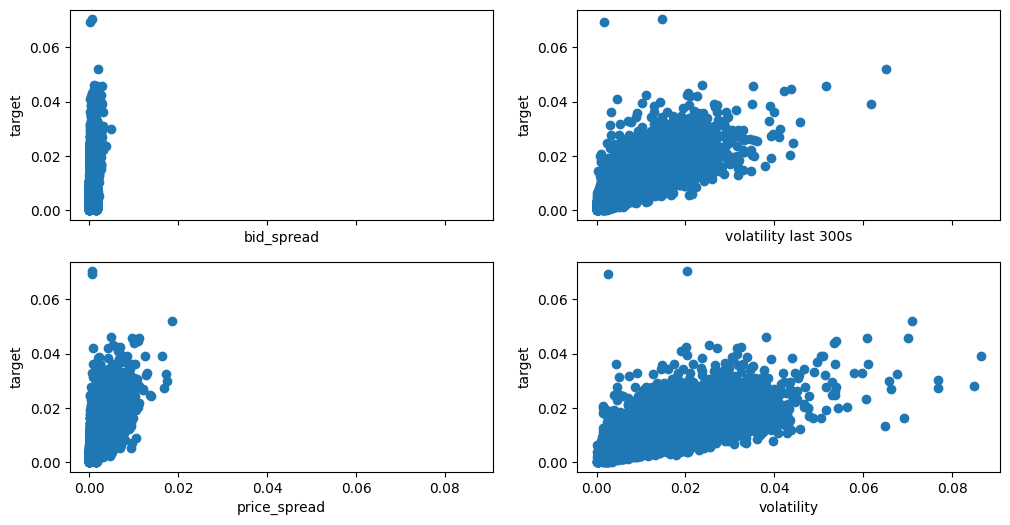

In [48]:
def plot_one_on_one_graph():
    fig, ax = plt.subplots(nrows=2, ncols=2,  figsize=(12, 6),sharex=True,squeeze=True)
    ax[0,0].scatter(Xtrain['bid_spread'],ytrain)
    ax[0,1].scatter(X_train['vol_300'],y_train)
    ax[1,0].scatter(X_train['price_spread'],y_train)
    ax[1,1].scatter(X_train['vol'],y_train)
    ax[0,0].update({'xlabel':'bid_spread', 'ylabel':'target'})
    ax[0,1].update({'xlabel':'volatility last 300s', 'ylabel':'target'})
    ax[1,0].update({'xlabel':'price_spread', 'ylabel':'target'})
    ax[1,1].update({'xlabel':'volatility', 'ylabel':'target'})
    plt.show()
plot_one_on_one_graph()

In [ ]:
# !pip install xgboost


********************  Gradient Boost Model  ********************

Fitting 2 folds for each of 36 candidates, totalling 72 fits
best score:  0.8185442472493953
best parameter {'eta': 0.3, 'gamma': 0, 'max_depth': 10, 'objective': 'reg:logistic'}
Performance  R square: 0.824 	|	 RMSPE :0.279


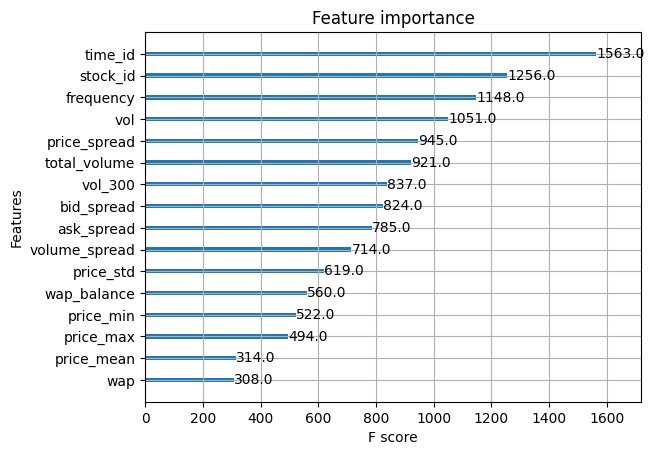

In [21]:
def GradientBoost_model():
    model = xgb.XGBRegressor()
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)
    params = { 
        'eta':[0.05,0.1, 0.3, 0.5],
        'gamma':[0],
        'objective': ['reg:squarederror', 'reg:pseudohubererror', 'reg:logistic' ],
        'max_depth': [3, 5, 10]}
    
    grid = GridSearchCV(model,
                        params,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

    grid.fit(X_train, y_train)
    y_pred = grid.best_estimator_.predict(X_test)
    print('best score: ',grid.best_score_)
    print('best parameter',grid.best_params_)
    print ('Performance  R square: %.3f \t|\t RMSPE :%.3f'%(metrics.r2_score(y_test, y_pred), rmspe(y_test, y_pred)))
    xgb.plot_importance(grid.best_estimator_)
    
print (make_title('Gradient Boost Model'))
GradientBoost_model()

In [45]:
def lgbm_param_search():
    X_train, X_valid, y_train, y_valid = train_test_split(X,y, test_size=0.3, random_state=2322)

    model = lightgbm.LGBMRegressor(
            boosting_type= 'gbdt', 
            objective='rmse',
            metric = 'rmse',
            early_stopping_rounds = 30)
    
    params = { 
    'learning_rate': [0.005, 0.01],
#     'num_leaves': [6, 12], # large num_leaves helps improve accuracy but might lead to over-fitting
    'reg_alpha' : [1],
    'reg_lambda' : [1],
        
    }
    
    grid = GridSearchCV(estimator=model, param_grid=params, cv=4, n_jobs=-1)
    grid.fit(X_train, y_train,eval_set = (X_valid, y_valid))   
    # Print the best parameters found
    
    
    print("*" * 100)

    print(grid.best_params_)
    print(grid.best_score_)
    
    y_pred = grid.best_estimator_.predict(X_valid)
    # validation 
    RMSPE = round(rmspe(y_valid, y_pred),3)
    print(f'Performance of the　prediction: , RMSPE: {RMSPE}')
    return grid.best_estimator_               
#     
    
    
bestmdl = lgbm_param_search()

[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006896 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3937
[LightGBM] [Info] Number of data points in the train set: 300239, number of used features: 16
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Info] Start training from score 0.003880
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 0.00167271
****************************************************************************************************
{'learn

[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.122878 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3937
[LightGBM] [Info] Number of data points in the train set: 225179, number of used features: 16
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Info] Start training from score 0.003882
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

In [41]:
# Xtrain

********************  LightGBM model   ********************

Fold : 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029630 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3937
[LightGBM] [Info] Number of data points in the train set: 343130, number of used features: 16
[LightGBM] [Info] Start training from score 0.001209
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[377]	training's rmse: 0.000345034	valid_1's rmse: 0.000353916
Performance of the　prediction: , RMSPE: 0.25
****************************************************************************************************
Fold : 2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004752 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3937
[LightGBM] [I

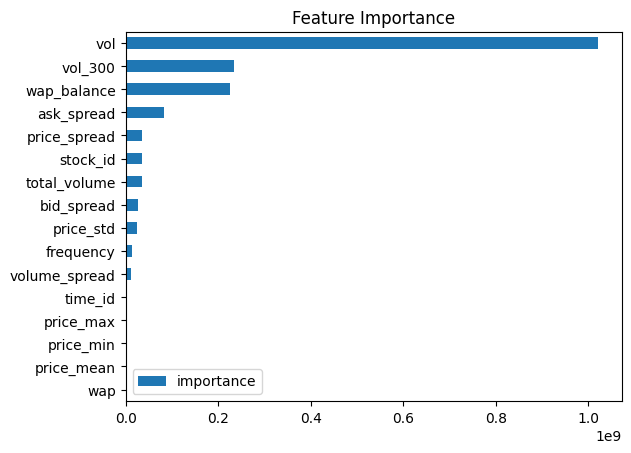

In [95]:
def LightGBModel():
    params = {
      "objective": "rmse", 
      "metric": "rmse", 
      "boosting_type": "gbdt",
      'early_stopping_rounds': 30,
      'learning_rate': 0.01,
      'lambda_l1': 1,
      'lambda_l2': 1,
      'feature_fraction': 0.8,
      'bagging_fraction': 0.8,
  }
    
    kf = KFold(n_splits=5, random_state=128, shuffle=True)
    models = []                          # models
    scores = 0.0                         # validation score
    
    for fold, (trn_idx, val_idx) in enumerate(kf.split(X, y)):

        print("Fold :", fold+1)

        # create dataset
        X_train, y_train = X.loc[trn_idx], y[trn_idx]
        X_valid, y_valid = X.loc[val_idx], y[val_idx]

        #RMSPE weight
        weights = 1/(y_train**2)  #square inverse weights
        lgbm_train = lightgbm.Dataset(X_train,y_train,weight = weights)
        
        weights = 1/(y_valid**2)  #square inverse weights
        lgbm_valid = lightgbm.Dataset(X_valid,y_valid,reference = lgbm_train,weight = weights)

        # model 
        model = lightgbm.train(
                        params=params,
                        train_set=lgbm_train,
                        valid_sets=[lgbm_train, lgbm_valid],
                        num_boost_round=5000,     
                        categorical_feature = ['stock_id']                
                         )

        # validation 
        y_pred = model.predict(X_valid, num_iteration=model.best_iteration)

        RMSPE = round(rmspe(y_true = y_valid, y_pred = y_pred),3)
        print(f'Performance of the　prediction: , RMSPE: {RMSPE}')

        #keep scores and models
        scores += RMSPE / 5
        models.append(model)
        print("*" * 100)
    print ('average rmsq score', scores)
        
    pd.DataFrame(model.feature_importance(importance_type='gain'),
                             index=list(X_train),columns=['importance']).sort_values('importance').plot.barh()
    plt.title('Feature Importance')
    plt.show()
print (make_title('LightGBM model '))
LightGBModel()